<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install tensorflow-gan tensorflow-addons imageio -q
!rm -rf sample_data BigGANUtils checkpoints samples
!mkdir checkpoints samples
!git clone https://github.com/xarvel/BigGANUtils.git

Cloning into 'BigGANUtils'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 67 (delta 39), reused 42 (delta 18), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [61]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Dense, Conv2D, Embedding, ReLU,  BatchNormalization, Reshape
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import numpy as np
from tqdm import tqdm 
import imageio
import glob
import IPython
import math
from BigGANUtils.SelfAttention import SelfAttention
from BigGANUtils.GBlock import GBlock
from BigGANUtils.DBlock import DBlock
from BigGANUtils.SpectralNormalization import SpectralNormalization
from BigGANUtils.ConditionalBatchNormalization import ConditionalBatchNormalization
print(tf.__version__)

2.9.2


In [62]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [63]:
#@title CONFIG

IMAGE_SIZE = 64
IMAGE_CHANNELS = 3 
DATASET_SIZE = 13262
BUFFER_SIZE = DATASET_SIZE
PER_REPILICA_BATCH_SIZE = 4
GLOBAL_BATCH_SIZE = PER_REPILICA_BATCH_SIZE * strategy.num_replicas_in_sync
EPOCHS = 25
LATENT_DIM = 120
CHECKPOINT_DIR = 'checkpoints'
SAMPLES_DIR = 'samples'
CHECKPOINT_INTERVAL = 10
SEED = 1
NUM_CLASSES = 100
TFRECORD_PATH = 'gs://brids-xarvel/*.tfrec'
SAMPLE_INTERVAL = 2

GAN_FILTERS = 16
GENERATOR_LR = 0.0001
DISCRIMINATOR_LR = 0.0004
ADAM_BETA_1 = 0.0
ADAM_BETA_2 = 0.99
ADAM_EPSILON = 1e-07

In [64]:
tf.random.set_seed(SEED)

weight_initializer = 'orthogonal' 

# weight_initializer = tf.keras.initializers.RandomNormal(
#     mean=0.0, stddev=0.02, seed=SEED
# )

In [65]:
#@title Dataset

def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    tfrecord_path: str,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(proto):
        features = {
          "image": tf.io.FixedLenFeature([], tf.string), 
          'height': tf.io.FixedLenFeature([], tf.int64),
          'width': tf.io.FixedLenFeature([], tf.int64),
          'channels': tf.io.FixedLenFeature([], tf.int64),
          'label_text': tf.io.FixedLenFeature([], tf.string), 
          'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
          'label_number': tf.io.FixedLenFeature([], tf.int64),
        }

        parsed = tf.io.parse_single_example(
            serialized=proto,
            features=features
        )

        image, label = parsed["image"], parsed["label_number"]
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (image_size, image_size))
    
        return image, label

    def augment(image, label):
      image = tf.image.random_flip_left_right(
          image, seed=SEED
      )

      return image, label  
    
    tfrecord_files = tf.io.gfile.glob(tfrecord_path)

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_example)
    
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True, seed=SEED)
      dataset = dataset.repeat()
      dataset = dataset.map(augment)

    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=GLOBAL_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=False
) 

In [66]:
#@title Generator

class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size):
    super(Generator, self).__init__()
    self.channels = channels
    self.linear = SpectralNormalization(Dense(4 * 4 * 16 * channels, use_bias=False, kernel_initializer=weight_initializer))
    self.reshape = Reshape([4, 4, 16 * channels])

    self.res_block_1 = GBlock(16 * channels, kernel_initializer=weight_initializer)
    self.res_block_2 = GBlock(8 * channels, kernel_initializer=weight_initializer)
    self.res_block_3 = GBlock(4 * channels, kernel_initializer=weight_initializer)
    self.attention = SelfAttention(kernel_initializer=weight_initializer)
    self.res_block_4 = GBlock(2 * channels, kernel_initializer=weight_initializer)
    self.embedding = Embedding(num_classes, embedding_size, embeddings_initializer=weight_initializer)

    self.bn = BatchNormalization()
    self.relu = ReLU()
    self.conv = SpectralNormalization(Conv2D(filters=IMAGE_CHANNELS, kernel_size=3, padding='same', kernel_initializer=weight_initializer))
    self.concat = Concatenate();

  @tf.function
  def call(self, z, label, training=False):    
    z_split = tf.split(z, num_or_size_splits=5, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1(x, conds[0], training=training)
    x = self.res_block_2(x, conds[1], training=training)
    x = self.res_block_3(x, conds[2], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_4(x, conds[3], training=training)
    x = self.bn(x, training=training)
    x = self.relu(x)
    x = self.conv(x, training=training)
    return tf.nn.tanh(x)    

In [67]:
#@title Discriminator

class Discriminator(Model):
  def __init__(self, channels, num_classes):
    super(Discriminator, self).__init__()
    self.res_block_1 = DBlock(1 * channels, downsample=True, preactivation=False, kernel_initializer=weight_initializer)
    self.res_block_2 = DBlock(2 * channels, downsample=True, preactivation=True, kernel_initializer=weight_initializer)
    self.res_block_3 = DBlock(4 * channels, downsample=True, preactivation=True, kernel_initializer=weight_initializer)
    self.res_block_4 = DBlock(8 * channels, downsample=True, preactivation=True, kernel_initializer=weight_initializer)
    self.attention = SelfAttention(kernel_initializer=weight_initializer)
    self.res_block_5 = DBlock(16 * channels, downsample=False, preactivation=True, kernel_initializer=weight_initializer)
    self.activation = ReLU()
    self.embedding = Embedding(num_classes, 16 * channels, embeddings_initializer=weight_initializer)

    self.linear = SpectralNormalization(
       Dense(1, kernel_initializer=weight_initializer)
    )
  
  @tf.function
  def call(self, x, label, training=False):
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_5(x, training=training)
    x = self.activation(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [68]:
with strategy.scope():
  generator = Generator(GAN_FILTERS, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM)
  discriminator = Discriminator(GAN_FILTERS, num_classes=NUM_CLASSES)

In [69]:
train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=PER_REPILICA_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=True
))

In [70]:
hinge = tf.keras.losses.Hinge(reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor :
  real_loss = hinge(tf.ones_like(logits_real), logits_real)
  fake_loss = hinge(tf.zeros_like(logits_fake), logits_fake)
  total_loss = real_loss + fake_loss

  return tf.nn.compute_average_loss(total_loss, global_batch_size=GLOBAL_BATCH_SIZE)

def generator_loss(logits_fake: tf.Tensor) -> tf.Tensor:
  loss = hinge(tf.ones_like(logits_fake), logits_fake)
  return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)


In [71]:
with strategy.scope():
  generator_optimizer = tf.keras.optimizers.Adam(
      learning_rate=GENERATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2,
      epsilon=ADAM_EPSILON
  )
  discriminator_optimizer = tf.keras.optimizers.Adam(
      learning_rate=DISCRIMINATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2, 
      epsilon=ADAM_EPSILON
  )

In [72]:
fixed_noise = tf.random.truncated_normal((NUM_CLASSES, LATENT_DIM), stddev=1)

def sample_images(epoch=0, save=False, show=True):
  square_size = int(math.sqrt(NUM_CLASSES))
  rows = square_size
  cols = square_size
  noise = fixed_noise

  labels = np.arange(0, NUM_CLASSES)
  gen_imgs = generator(noise, labels)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(
      wspace = 0.0,
      hspace = 0.0
  )
  px = 1/plt.rcParams['figure.dpi']

  fig.set_figheight(IMAGE_SIZE * rows * px)
  fig.set_figwidth(IMAGE_SIZE * cols * px)

  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * square_size + i])
  
      axs[i,j].axis('off')

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(SAMPLES_DIR, exist_ok=True)

  if save:
    plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
    
  if show:
    plt.show()
  else:
    plt.close(fig)

def sample_analytics(meta, save=False, show=True):
  history = meta['history']

  with plt.xkcd():
    fig, axs = plt.subplots(figsize=(10,10))
    plt.plot(history['gen_loss'], label='Generator loss')
    plt.plot(history['disc_loss'], label='Discriminator loss')
    plt.title('Learing process')
    
    plt.figtext(.7, .17, '\n'.join([
        'Epoch=%s' % meta['epoch'],
        "GEN_LR=%s" % GENERATOR_LR,
        'DISC_LR=%s' % DISCRIMINATOR_LR,
        'FILTERS=%s' % GAN_FILTERS,
        'PER_REPILICA_BATCH_SIZE=%s' % PER_REPILICA_BATCH_SIZE
    ]))

    fig.legend();

    if save:
      fig.savefig(SAMPLES_DIR + '/analytics_at_epoch_{:04d}.png'.format(meta['epoch'])) 
  
    if show:   
      plt.show()
    else:
      plt.close(fig)

In [73]:
#@title checkpoint
import json

with strategy.scope():
  current_epoch = tf.Variable(1);

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)

defaultMeta = {
    "history": {
        "disc_loss": [],
        "gen_loss": []
    },
    "epoch": 1
}
meta = defaultMeta

META_FILE = CHECKPOINT_DIR + '/meta.json'

def restore_checkpoint():
  try:
    with open(META_FILE) as f:
      meta = json.load(f)
  except:
    meta = defaultMeta
    pass
  
  status = checkpoint.restore(latest_checkpoint, options=local_device_option)
  return meta

def save_checkpoint():
  print('Saving checkpoint');

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

  with open(META_FILE, 'w') as f:
    json.dump(meta, f)
  
  checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

meta = restore_checkpoint();

(1, 64, 64, 3)


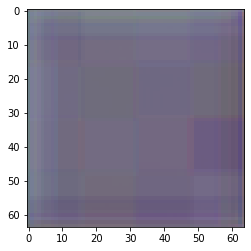

In [74]:
with strategy.scope():
  label = tf.constant([1])
  noise = tf.random.truncated_normal([1, 120], stddev=0.5)
  generated_image = generator(noise, label, training=False)
  print(generated_image.shape)
  plt.imshow(generated_image[0] * 0.5 + 0.5)  

In [75]:
with strategy.scope():
  decision = discriminator(generated_image, label)
  print(decision)

tf.Tensor([[-0.7286969]], shape=(1, 1), dtype=float32)


In [76]:
#@title train_step

with strategy.scope():
  d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
  g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

@tf.function
def train_step(iterator):
  """The step function for one training step."""

  def step_fn(inputs):
    """The computation to run on each TPU device."""
    images, labels = inputs
    noise = tf.random.normal([PER_REPILICA_BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
      tape.watch(generator.trainable_weights + discriminator.trainable_weights)

      generated_images = generator(noise, labels, training=True)
      gen_predictions = discriminator(generated_images, labels, training=True)
      real_predictions = discriminator(images, labels, training=True)
      disc_loss = discriminator_loss(real_predictions, gen_predictions)
      gen_loss = generator_loss(gen_predictions)

    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_weights)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_weights)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
    discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_weights)
    )
    
    d_loss_metric.update_state(disc_loss)
    g_loss_metric.update_state(gen_loss)
    
    return disc_loss, gen_loss

  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, gen_loss, axis=None)
  
  return disc_loss, gen_loss

In [77]:
steps_per_epoch = DATASET_SIZE // PER_REPILICA_BATCH_SIZE
train_iterator = iter(train_dataset)

for epoch in range(meta['epoch'], EPOCHS + 1):
  meta['epoch'] = epoch
  start = time.time()
  print('Epoch: {}/{}'.format(epoch, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
    meta['history']['disc_loss'].append(float(disc_loss));
    meta['history']['gen_loss'].append(float(gen_loss));
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if epoch % SAMPLE_INTERVAL == 0:
    sample_images(epoch, save=True, show=False)
    
  if epoch % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()
    sample_analytics(meta, save=True, show=False)   

  print('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

Epoch: 1/25


  0%|          | 0/3315 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall_1:2", shape=(4,), dtype=int64), values=Tensor("PartitionedCall_1:1", shape=(4, 120), dtype=float32), dense_shape=Tensor("PartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("concat_1:0", shape=(8,), dtype=int64), values=Tensor("concat:0", shape=(8, 256), dtype=float32), dense_shape=Tensor("PartitionedCall_2:64", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
Current step 3315: 100%|██████████| 3315/3315 [08:01<00:00,  6.88it/s, disc_loss=0.03

Time for epoch 1 is 481.90434217453003 sec
Epoch: 2/25


Current step 6630: 100%|██████████| 3315/3315 [02:20<00:00, 23.53it/s, disc_loss=0.114, gen_loss=0.214]


Time for epoch 2 is 147.27857518196106 sec
Epoch: 3/25


Current step 9945: 100%|██████████| 3315/3315 [02:19<00:00, 23.68it/s, disc_loss=0.0337, gen_loss=0.463]


Time for epoch 3 is 139.97916293144226 sec
Epoch: 4/25


Current step 13260: 100%|██████████| 3315/3315 [02:21<00:00, 23.46it/s, disc_loss=0.0459, gen_loss=0.398]


Time for epoch 4 is 143.7113757133484 sec
Epoch: 5/25


Current step 16575: 100%|██████████| 3315/3315 [02:19<00:00, 23.78it/s, disc_loss=0.0171, gen_loss=0.421]


Time for epoch 5 is 139.42905950546265 sec
Epoch: 6/25


Current step 19890: 100%|██████████| 3315/3315 [02:19<00:00, 23.77it/s, disc_loss=0.0527, gen_loss=0.315]


Time for epoch 6 is 141.96793007850647 sec
Epoch: 7/25


Current step 23205: 100%|██████████| 3315/3315 [02:22<00:00, 23.22it/s, disc_loss=0.0176, gen_loss=0.465]


Time for epoch 7 is 142.7646028995514 sec
Epoch: 8/25


Current step 26520: 100%|██████████| 3315/3315 [02:21<00:00, 23.37it/s, disc_loss=0.0483, gen_loss=0.378]


Time for epoch 8 is 144.31061840057373 sec
Epoch: 9/25


Current step 29835: 100%|██████████| 3315/3315 [02:21<00:00, 23.48it/s, disc_loss=0.0052, gen_loss=0.529]


Time for epoch 9 is 141.2140383720398 sec
Epoch: 10/25


Current step 33150: 100%|██████████| 3315/3315 [02:20<00:00, 23.59it/s, disc_loss=0.0231, gen_loss=0.445]


Saving checkpoint
Time for epoch 10 is 147.77281308174133 sec
Epoch: 11/25


Current step 36465: 100%|██████████| 3315/3315 [02:20<00:00, 23.62it/s, disc_loss=0.0567, gen_loss=0.524]


Time for epoch 11 is 140.3540804386139 sec
Epoch: 12/25


Current step 39780: 100%|██████████| 3315/3315 [02:20<00:00, 23.64it/s, disc_loss=0.0474, gen_loss=0.366]


Time for epoch 12 is 142.65021347999573 sec
Epoch: 13/25


Current step 43095: 100%|██████████| 3315/3315 [02:20<00:00, 23.57it/s, disc_loss=0.0265, gen_loss=0.433]


Time for epoch 13 is 140.66708898544312 sec
Epoch: 14/25


Current step 46410: 100%|██████████| 3315/3315 [02:21<00:00, 23.48it/s, disc_loss=0.04, gen_loss=0.339]


Time for epoch 14 is 143.63495779037476 sec
Epoch: 15/25


Current step 49725: 100%|██████████| 3315/3315 [02:21<00:00, 23.41it/s, disc_loss=0.0152, gen_loss=0.489]


Time for epoch 15 is 141.59339022636414 sec
Epoch: 16/25


Current step 53040: 100%|██████████| 3315/3315 [02:21<00:00, 23.43it/s, disc_loss=0.0652, gen_loss=0.25]


Time for epoch 16 is 153.5033643245697 sec
Epoch: 17/25


Current step 56355: 100%|██████████| 3315/3315 [02:23<00:00, 23.07it/s, disc_loss=0.0479, gen_loss=0.371]


Time for epoch 17 is 143.6802580356598 sec
Epoch: 18/25


Current step 59670: 100%|██████████| 3315/3315 [02:22<00:00, 23.23it/s, disc_loss=0.0301, gen_loss=0.468]


Time for epoch 18 is 145.05361652374268 sec
Epoch: 19/25


Current step 62985: 100%|██████████| 3315/3315 [02:25<00:00, 22.74it/s, disc_loss=0.0341, gen_loss=0.398]


Time for epoch 19 is 145.79624152183533 sec
Epoch: 20/25


Current step 66300: 100%|██████████| 3315/3315 [02:23<00:00, 23.02it/s, disc_loss=0.0225, gen_loss=0.484]


Saving checkpoint
Time for epoch 20 is 151.6718406677246 sec
Epoch: 21/25


Current step 69615: 100%|██████████| 3315/3315 [02:20<00:00, 23.63it/s, disc_loss=0.0101, gen_loss=0.447]


Time for epoch 21 is 140.27686715126038 sec
Epoch: 22/25


Current step 72930: 100%|██████████| 3315/3315 [02:20<00:00, 23.57it/s, disc_loss=0.0369, gen_loss=0.401]


Time for epoch 22 is 143.04686951637268 sec
Epoch: 23/25


Current step 76245: 100%|██████████| 3315/3315 [02:21<00:00, 23.36it/s, disc_loss=0.0279, gen_loss=0.404]


Time for epoch 23 is 141.89256024360657 sec
Epoch: 24/25


Current step 79560: 100%|██████████| 3315/3315 [02:22<00:00, 23.27it/s, disc_loss=0.0192, gen_loss=0.412]


Time for epoch 24 is 144.79652667045593 sec
Epoch: 25/25


Current step 82875: 100%|██████████| 3315/3315 [02:22<00:00, 23.26it/s, disc_loss=0.0286, gen_loss=0.393]

Time for epoch 25 is 142.53927636146545 sec


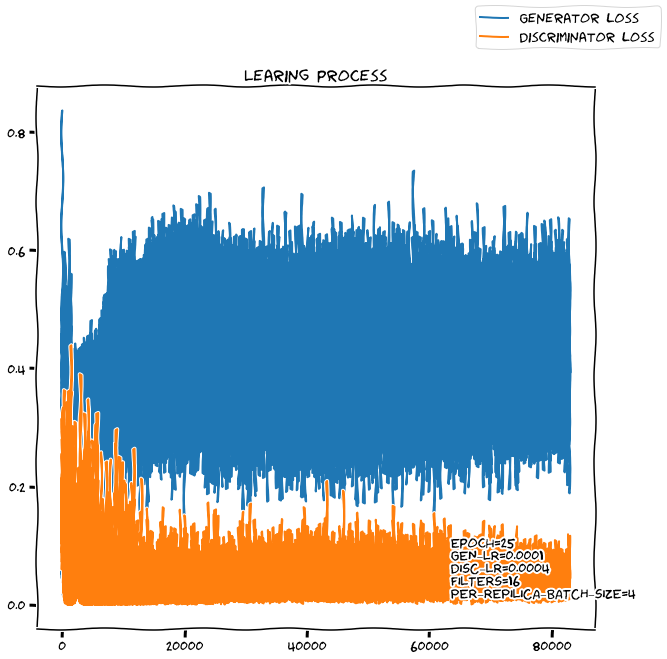

In [78]:
sample_analytics(meta, save=False, show=True)    

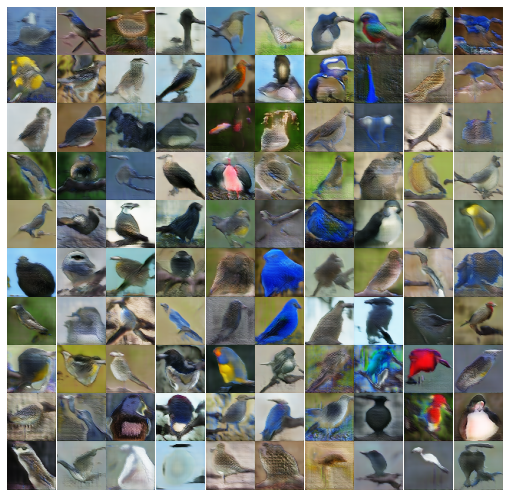

In [79]:
sample_images(meta['epoch'], save=False, show=True)

In [80]:
samples = SAMPLES_DIR + '/samples.gif'

with imageio.get_writer(samples, mode='I') as writer:
  filenames = glob.glob(SAMPLES_DIR + '/image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

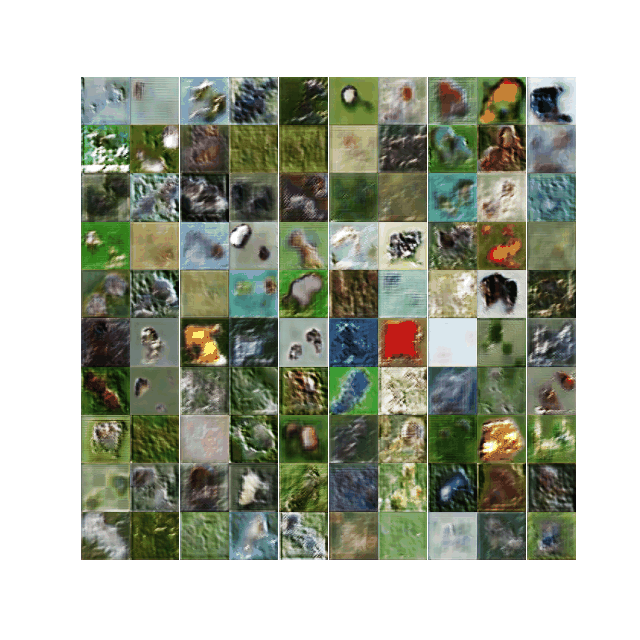

In [81]:
IPython.display.Image(filename=samples, embed=True)